# AIAA 2020 figures related to measurement of electrical characteristics (Figure 2 and 3)

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
from pandas import Timestamp

import matplotlib.dates as mdates 

from mhdpy import *

import mhdpy

import pytz
%matplotlib inline
mpl.rcParams.update({'font.size': 18, 'timezone': pytz.timezone('America/Los_Angeles')})

In [3]:
finalanalysisfolder = os.getcwd() #Folder with notebooks
dsst = mhdpy.load.loadprocesseddata(os.path.join(finalanalysisfolder, 'Data', 'dsst'))

with open(os.path.join(finalanalysisfolder, 'Data', 'da_ct.pickle'), 'rb') as file:
    da_ct = pickle.load(file)
    
ds_nhr = dsst['nhr']

## 07-01 time  and I-V plots

In [4]:
da_ct_0701, da_ct_0701_stack = analysis.ct.reset_da_ct(da_ct.sel(date='2020-07-01'), keep_attrs=True)
region = analysis.ct.get_region(da_ct_0701, buffer = 0.04)

Coordinate  date had no corresponding dimension, dropping


In [5]:
da_ct_0701_stack

<xarray.DataArray (ct: 5)>
array([slice(numpy.datetime64('2020-07-01T17:47:45.824500736'), numpy.datetime64('2020-07-01T17:48:48.918406912'), None),
       slice(numpy.datetime64('2020-07-01T17:53:20.967049472'), numpy.datetime64('2020-07-01T17:54:23.048440320'), None),
       slice(numpy.datetime64('2020-07-01T17:50:31.877002240'), numpy.datetime64('2020-07-01T17:51:33.958393088'), None),
       slice(numpy.datetime64('2020-07-01T17:58:08.015123456'), numpy.datetime64('2020-07-01T17:59:12.627802112'), None),
       slice(numpy.datetime64('2020-07-01T18:00:28.905457920'), numpy.datetime64('2020-07-01T18:01:21.067949312'), None)],
      dtype=object)
Coordinates:
  * ct       (ct) MultiIndex
  - Kwt      (ct) float64 0.1 0.1 0.1 0.32 1.0
  - tf       (ct) float64 9.52 12.96 16.38 12.96 12.96

Text(0, 0.5, 'Current \n Density ($A/cm^2$)')

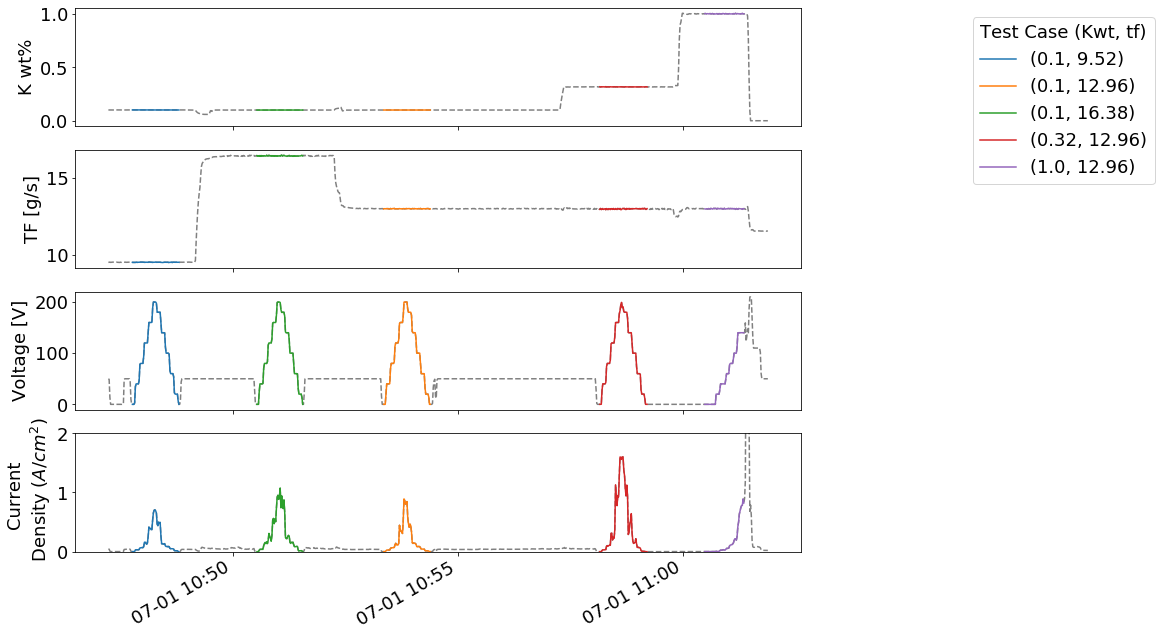

In [6]:
#choose the dataarrays to be plotted
ds = xr.merge([dsst['hvof_input_calcs']['Kwt_hvof'], dsst['hvof_input_calcs']['totalmassflow_hvof'],ds_nhr['V'],ds_nhr['J']]).sel(time=region).dropna('time')

fig = plot.common.tc_plot(ds, da_ct_0701_stack, yspace=3, grid=False)
fig.get_axes()[0].get_legend().set_bbox_to_anchor([0,0,1.5,1])

fig.get_axes()[3].set_ylim(0,2)
fig.get_axes()[3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M')) 

for ax in fig.get_axes():
    ax.set_xlabel(None)
    
#Manual Tweaks
fig.set_size_inches(13,10)
fig.get_axes()[1].set_ylabel('TF [g/s]')
fig.get_axes()[2].set_ylabel('Voltage [V]')
fig.get_axes()[3].set_ylabel('Current \n Density ($A/cm^2$)')

In [7]:
ds = analysis.ct.assign_tc_general(ds_nhr, da_ct_0701)

da_mean, da_std = analysis.gen.bin_gen(ds, curname='J', voltname='V',bins = np.arange(-5,605,1), min_points=5)

da_mean

da_mean = da_mean.stack(ct=('Kwt','tf')).dropna('ct','all')
da_std = da_std.stack(ct=('Kwt','tf')).dropna('ct','all')

da_mean.coords['ct'].attrs =dict(long_name='Test Case (K wt%, TF)')

C:\Users\aspit\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


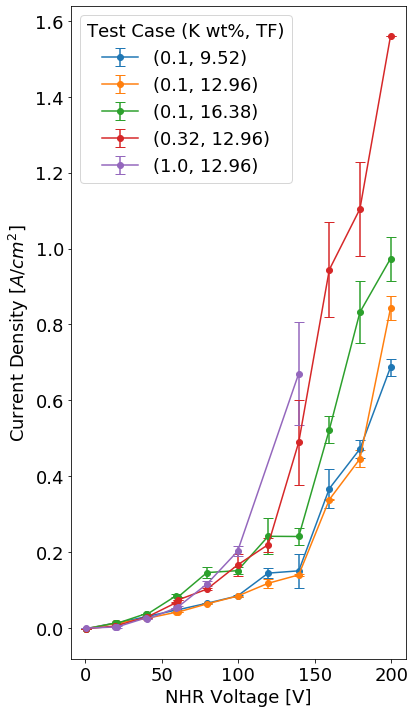

In [8]:
plot.common.xr_errorbar(da_mean,da_std, huedim='ct', capsize =5)
# plt.gca().get_legend().remove()
plt.gcf().set_size_inches(6, 12)

# All dates I-V plots

In [9]:
ylim = (0,0.25)

## No seed 

The no seed cases were taken at slightly different total flows than the seeded cases. take the mean over tf to just get rid of tf dimension. need to specify in text what tf goes to what


In [10]:
with open(os.path.join(finalanalysisfolder, 'Data', 'da_ct_noseed.pickle'), 'rb') as file:
    da_ct_noseed = pickle.load(file)
    

ds_noseed = analysis.ct.assign_tc_general(ds_nhr,da_ct_noseed)#.sel(Kwt=0)
da_mean, da_std = analysis.gen.bin_gen(ds_noseed , curname='J', voltname='V')
da_mean = da_mean.sel(voltage=slice(0,100))
da_std = da_std.sel(voltage=slice(0,100))

C:\Users\aspit\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


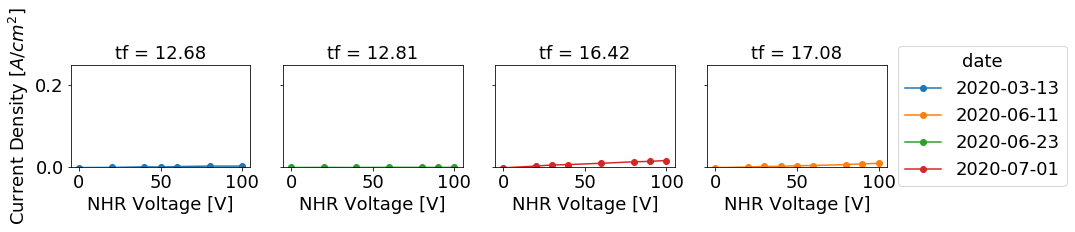

In [11]:
g = da_mean.plot(hue='date', col='tf', marker ='o', ylim= ylim)
plot.dropna(g)

## seeded cases combined artifically with Kwt =0

Artifically setting tf of the no seed dataset to the middle seeded case tf (12.96). This should be mentioned in the text

C:\Users\aspit\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Users\aspit\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


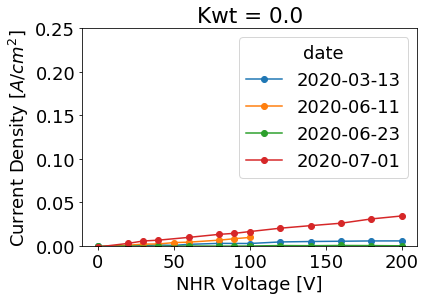

In [12]:
ds_noseed_combinetf = ds_noseed.mean('tf', keep_attrs = True)

da_mean, da_std = analysis.gen.bin_gen(ds_noseed_combinetf, curname='J', voltname='V')
g = da_mean.plot(hue='date', marker ='o', ylim= ylim)
plot.dropna(g)

In [13]:
ds_seed = analysis.ct.assign_tc_general(ds_nhr,da_ct)

ds_noseed_altertf = ds_noseed_combinetf.assign_coords(tf=ds_seed.coords['tf'].values[1]).expand_dims('tf')
ds = xr.merge([ds_noseed_altertf,ds_seed])

da_mean, da_std = analysis.gen.bin_gen(ds, curname='J', voltname='V')

da_mean = da_mean.sel(voltage=slice(0,100))
da_std = da_std.sel(voltage=slice(0,100))

C:\Users\aspit\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


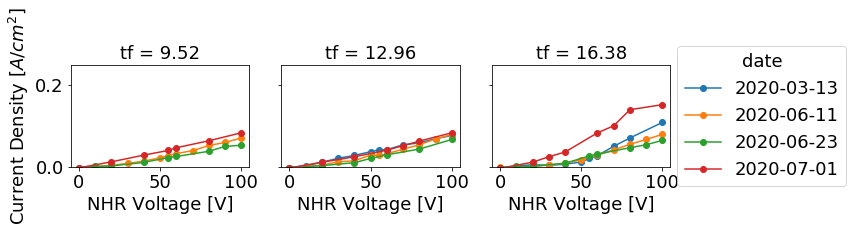

In [14]:
g = da_mean.sel(Kwt=0.1,method='nearest').plot(col='tf', hue='date', marker='o', sharey=True, ylim= ylim)
plot.dropna(g)

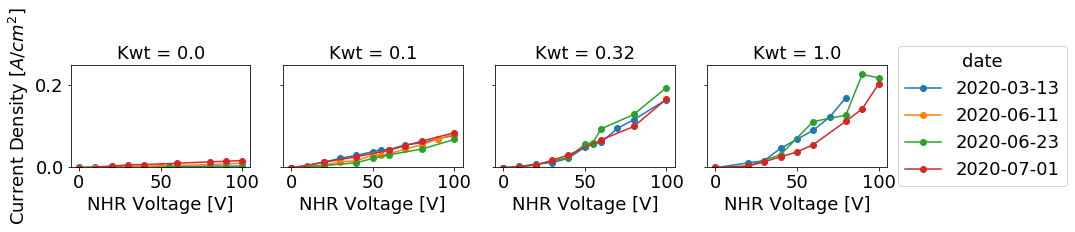

In [15]:
g = da_mean.sel(tf=12.9,method='nearest').plot(col='Kwt', hue='date', marker='o', sharey=True, ylim= ylim)
plot.dropna(g)

### with error bars

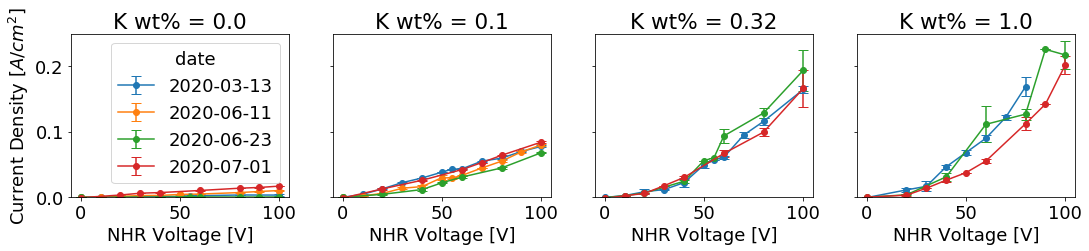

In [16]:
coldim = 'Kwt'
huedim = 'date'

m = da_mean.sel(tf=12.9,method='nearest')
s = da_std.sel(tf=12.9,method='nearest')

g = xr.plot.FacetGrid(m,col=coldim,figsize = (18,3))

axes_list=g.axes.flatten()

for i, ax in enumerate(axes_list):
    d = g.name_dicts.flatten()[i]
    plot.common.xr_errorbar_axes(m.sel(d).drop(coldim), s.sel(d).drop(coldim), ax, huedim=huedim, capsize=5)
    
    if i!=0:
        ax.set_ylabel('')
    
    if i != 0:
        ax.get_legend().remove()
#     else:
#         ax.get_legend().set_bbox_to_anchor([0,0,2,1])
        
    ax.set_title('K wt%' + ' = ' + str(d[coldim]))
    ax.set_ylim(ylim)
    
plot.dropna(g)

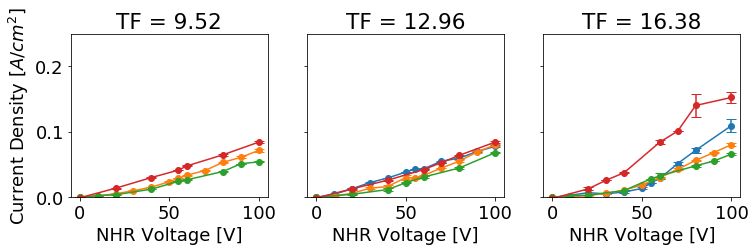

In [17]:
coldim = 'tf'
huedim = 'date'

m = da_mean.sel(Kwt=0.1,method='nearest')
s = da_std.sel(Kwt=0.1,method='nearest')

# g = xr.plot.FacetGrid(m,col=coldim,figsize = (13.33,3))
g = xr.plot.FacetGrid(m,col=coldim,figsize = (12,3))

axes_list=g.axes.flatten()

for i, ax in enumerate(axes_list):
    d = g.name_dicts.flatten()[i]
    plot.common.xr_errorbar_axes(m.sel(d).drop(coldim), s.sel(d).drop(coldim), ax, huedim=huedim, capsize=5)
    
    if i!=0:
        ax.set_ylabel('')
    
#     if i != len(axes_list)-1:
    ax.get_legend().remove()
#     else:
#         ax.get_legend().set_bbox_to_anchor([0,0,2.2,1])
        
    ax.set_title('TF' + ' = ' + str(d[coldim]))
    ax.set_ylim(ylim)
    
plot.dropna(g)

## Calculate resistance and average over dates

Note that current 'I' is selected instead of 'J'

In [18]:
da_mean, da_std = analysis.gen.bin_gen(ds, curname='I', voltname='V')

da_mean_highV = da_mean.sel(voltage=slice(50,100)).drop(0.0, 'Kwt')

resist = da_mean_highV.coords['voltage']/da_mean_highV
resist = resist.mean('voltage', keep_attrs=True)
resist.attrs = dict(long_name = '$R_{expt}$ (50-100V) ', units = 'ohms')
resist = resist.where(resist>0)
resist = resist.where(resist<5000)
resist.name = 'resistance'

C:\Users\aspit\anaconda3\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [19]:
resist_kohm = resist/1000
resist_kohm.attrs = dict(long_name='$R_{expt}$ (50-100V)', units ='Kohm')

In [20]:
resist_kohm = resist_kohm.rename(tf='TF')

resist_mean = resist_kohm.mean('date', keep_attrs=True)
resist_std = resist_kohm.std('date', keep_attrs=True)

(0, 1.8)

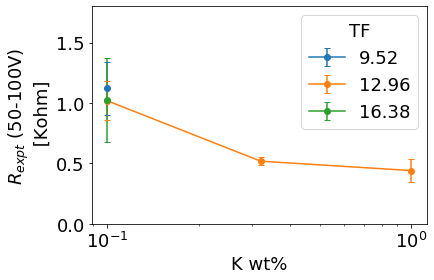

In [21]:
plot.common.xr_errorbar(resist_mean, resist_std, huedim='TF')

plt.ylabel('$R_{expt}$ (50-100V) \n [Kohm]')

plt.xscale('log')
plt.ylim(0,1.8)